# Fast Filtering with Large Option Panels: Implications for Asset Pricing

As we don't have access to the data used in the paper, we will simulate data from the option pricing models whown in the figures (page 59 environ) and then estimate the model given the artificial data.

In [65]:
import matplotlib.pyplot as plt

import simulation

## 1. Simulating data

### 1.1. SV Heston model

We will first simulate the data from the simple Stochastic Volatility model of Heston. The model is given by the following SDEs:

$$
\begin{aligned}
dS_t &= (r_t - \delta_t + \eta_s V_t) S_t dt + \sqrt{V_t} S_t dW_t^S \\
dV_t &= \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_t^v
\end{aligned}
$$

where $W_t^S$ and $W_t^v$ are two correlated Brownian motions with correlation $\rho$. We will simulate the data for the following parameters:

We will start by the state on the 1st of January 2014 and simulate the data for 100 days with 30 options per day.

In [66]:
# Params
S0 = 1824.36
V0 = 0.0001
T = 100/365 # Time in days
N = 100 

r = 0.01
delta = 0.0509

# Params from the article
kappa = 1.6999
theta = 0.0334
sigma = 0.3715
rho = -0.9085
eta_s = 2.6623
eta_v = 1.1156

simuSV = simulation.SimulationSV(kappa, theta, sigma, rho, eta_s, eta_v)

# Simulate
S, V = simuSV.SV_heston(S0, V0, r, delta, T, N)

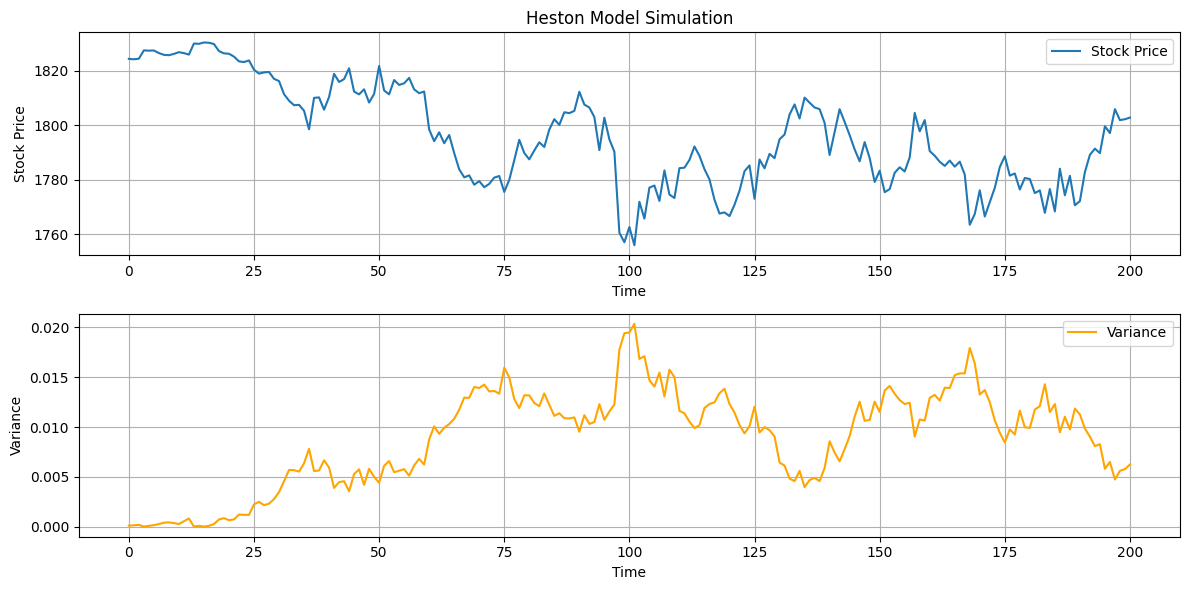

In [67]:
# time
time = [i for i in range(N+1)]

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, S, label="Stock Price")
plt.title("Heston Model Simulation")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, V, label="Variance", color="orange")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### 1.2. SVJR model

In [68]:
# Params from the article
kappa = 1.5382
theta = 0.0236
sigma = 0.3682
rho = -0.9187
eta_s = 2.5562
eta_v = 1.2466
lmda = 0.6380
mu_s = -0.0064
sigma_s = 0.0937
eta_js = 0.03
sigma_c = 3.0308

simuSVJR = simulation.SimulationSVJR(kappa, theta, sigma, rho, eta_s, eta_v, lmda, mu_s, sigma_s, eta_js, sigma_c)

# Simulate
S, V = simuSVJR.SVJR(S0, V0, r, delta, T, N)

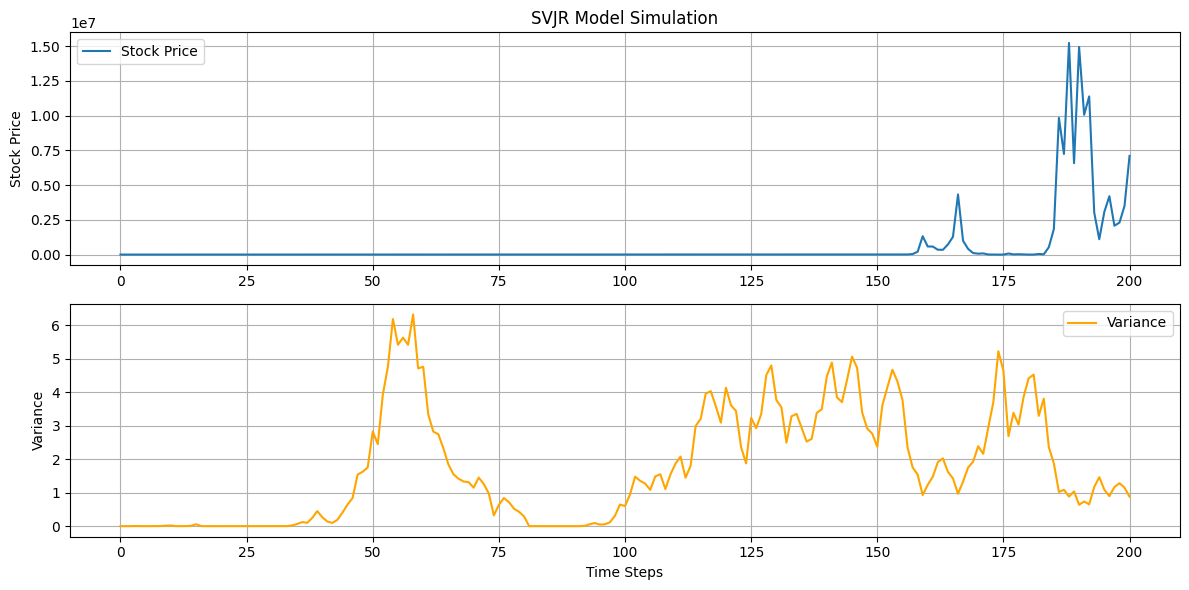

In [69]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(S, label="Stock Price")
plt.title("SVJR Model Simulation")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(V, label="Variance", color="orange")
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### 1.3. SVJV model

In [70]:
# Params from the article
kappa = 1.1777
theta = 0.0310
sigma = 0.3651
rho = -0.9242
eta_s = 2.3032
eta_v = 0.5569
lmda = 0.6716
mu_v = 0.0314
eta_jv = -0.0057
sigma_c = 3.0963

simuSVJV = simulation.SimulationSVJV(kappa, theta, sigma, rho, eta_s, eta_v, lmda, mu_v, eta_jv, sigma_c)

# Simulate
S, V = simuSVJV.SVJV(S0, V0, r, delta, T, N)

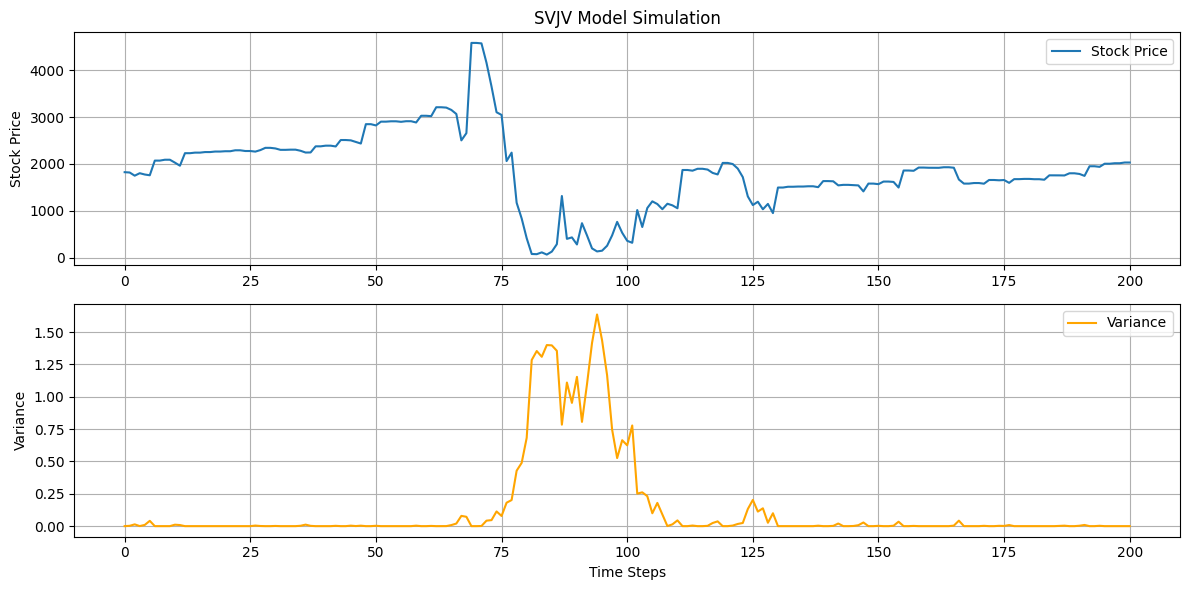

In [71]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(S, label="Stock Price")
plt.title("SVJV Model Simulation")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(V, label="Variance", color="orange")
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### 1.4. SVCJ model

## 2. Boostrap Filter (Feynman-Kac) for the model under consideration

In this section, we will implement the boostrap filter for the model under consideration. The boostrap filter is a Monte Carlo method that allows to estimate the filtering distribution of the state variables given the observations. The algorithm is as follows:

1. Initialize the particles $x_0^{(i)}$ for $i=1,\ldots,N$ from the prior distribution $p(x_0)$.

2. For $t=1,\ldots,T$:
    1. For $i=1,\ldots,N$:
        1. Sample $x_t^{(i)}$ from the proposal distribution $q(x_t|x_{t-1}^{(i)},y_t)$.
        2. Compute the importance weight $w_t^{(i)} = \frac{p(y_t|x_t^{(i)}) p(x_t^{(i)}|x_{t-1}^{(i)})}{q(x_t^{(i)}|x_{t-1}^{(i)},y_t)}$.
    2. Normalize the weights $w_t^{(i)}$.
    3. Resample the particles $x_t^{(i)}$ with replacement according to the weights $w_t^{(i)}$.

3. Compute the estimate of the filtering distribution as $\hat{p}(x_t|y_{1:t}) = \sum_{i=1}^N w_t^{(i)} \delta_{x_t^{(i)}}(x_t)$.

We will implement the boostrap filter for the model under consideration.